In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel)
import gc

In [3]:
from shopee_utils import *

In [4]:
OUTPUT_CLASSES=11014
TAKE_PAIRS = 5

In [5]:
TRIAL_RUN=True

In [6]:
conf = {
    'bs':64,
    'arch':resnet34,
    'split':0
}

In [7]:
PATH = Path('../input/shopee-product-matching')
image_model_file  = '../input/shopee-models/resnet34_arcface.pth'
text_model_file  = '../input/shopee-models/bert823val.pth'
text_model_file  = '../input/shopee-models/distilbert817val.pth'
BERT_PATH = '../input/bertindo15g'

if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')
    image_model_file ='models/resnet34_arcface.pth'
    text_model_file='./models/bert823val.pth'
    BERT_PATH = './bert_indonesian'
# BERT_PATH='cahya/distilbert-base-indonesian'
# text_model_file  = './models/distilbert817val.pth'

In [8]:
def hash_label(x):
    x = (13*x)%10000
    return x // 2000
train_df = pd.read_csv(PATH/'train.csv')
train_df['split']=train_df.label_group.apply(hash_label)
train_df['is_valid'] = train_df.split==conf['split']
valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

## TEXT

In [9]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        emb_dim=768
        mid_size = 512
        self.initial_layers=nn.Sequential(
            nn.BatchNorm1d(emb_dim),
            nn.Dropout(.25))
        self.W = nn.Parameter(torch.Tensor(emb_dim, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x = self.initial_layers(x)
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    
    
def arcface_loss(cosine, targ, m=.5, s=30):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = OUTPUT_CLASSES) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)

In [11]:
class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
        #self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH)
        
        
    def encodes(self, row):
        text = row.title
        encodings = self.tokenizer(text, padding = 'max_length', max_length=50, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask', 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

In [12]:
tfm = TitleTransform()

data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=tfm), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
text_dls = data_block.dataloaders(train_df, bs=256,num_workers=16)


In [13]:
class BertArcFace(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
        self.classifier = ArcFaceClassifier(768, OUTPUT_CLASSES)
        self.outputEmbs = False
    def forward(self, x):
        output = self.bert_model(*x)
        embeddings = output.last_hidden_state[:,0,:]#output.pooler_output
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)


In [14]:
def new_text_model():
    #bert_model = DistilBertModel.from_pretrained(BERT_PATH)
    bert_model = BertModel.from_pretrained(BERT_PATH)
    return BertArcFace(bert_model)

In [15]:
def generate_text_pairs(dl):
    model = new_text_model()
    state = torch.load(text_model_file)
    model.load_state_dict(state['model'])
    model.eval().cuda()
    model.outputEmbs=True
    embs, ys = embs_from_model(model, dl)
    target_matrix = ys[:,None]==ys[None,:]
    groups = [torch.where(t)[0].tolist() for t in target_matrix]
    dists, inds = get_nearest(embs, do_chunk(embs))
    pairs = sorted_pairs(dists, inds)[:len(embs)*10]
    return pairs, groups

In [16]:
# pairs, groups = generate_text_pairs(text_dls.valid)
# _=build_from_pairs(pairs, groups, True)

## IMAGE


In [17]:
class ArcFaceImgClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    
class ResnetArcFace(nn.Module):
    def __init__(self, output_classes):
        super().__init__()
        self.body = create_body(conf['arch'], cut=-2, pretrained=False)
        nf = num_features_model(nn.Sequential(*self.body.children()))
        self.after_conv=nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(nf*2),
            nn.Dropout(.25))
        self.classifier = ArcFaceImgClassifier(nf*2, output_classes)
        self.outputEmbs = False
        
    def forward(self, x):
        x = self.body(x)
        embeddings = self.after_conv(x)
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)

In [18]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

In [19]:
def generate_image_pairs(model, dl):
    embs, _ = embs_from_resnet(model, dl)
    dists, inds = get_nearest(embs, do_chunk_img(embs))
    pairs = sorted_pairs(dists, inds)[:int(len(embs)*TAKE_PAIRS)]
    return pairs

In [20]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls_image = data_block.dataloaders(train_df, bs=conf['bs'])


In [21]:
def generate_image_pairs(dl):
    model = ResnetArcFace(dls_image.c)
    state = torch.load(image_model_file)
    model.load_state_dict(state['model'])
    model = model.cuda().eval()
    model.outputEmbs = True
    embs, ys = embs_from_model(model, dl)
    target_matrix = ys[:,None]==ys[None,:]
    groups = [torch.where(t)[0].tolist() for t in target_matrix]
    dists, inds = get_nearest(embs, do_chunk(embs))
    pairs = sorted_pairs(dists, inds)[:len(embs)*10]
    return pairs, groups

In [22]:
# pairs, groups = generate_image_pairs(dls_image.valid)
# _=build_from_pairs(pairs, groups, True)

## COMBINE

In [23]:
def weave(A,B):
    R = list()
    used = set()
    for a,b in zip(A,B):
        if a[:2] not in used:
            R.append(a)
            used.add(a[:2])
        if b[:2] not in used:
            R.append(b)
            used.add(b[:2])
    return R

## Check on validation set

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

0.823 at 6.0207109451293945 pairs
0.780 at 4.938601493835449 pairs
0.870 at 6.094888210296631 pairs


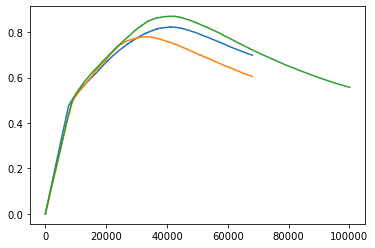

In [24]:
if TRIAL_RUN:
    text_pairs, targets = generate_text_pairs(text_dls.valid)

    img_pairs,_ = generate_image_pairs(dls_image.valid)

    combined = weave(text_pairs, img_pairs)



    _=build_from_pairs(text_pairs, targets)

    _=build_from_pairs(img_pairs,targets)



    _=build_from_pairs(combined, targets)

## Run on the test set

In [ ]:
test_df = pd.read_csv(PATH/'test.csv')

In [ ]:
if TRIAL_RUN:
    fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title', 'label_group']].copy()
    fake_test_df = pd.concat([fake_test_df, fake_test_df])
    fake_test_df = add_target_groups(fake_test_df)
    test_df = fake_test_df

In [ ]:
text_pairs,_ = generate_text_pairs(text_dls.test_dl(test_df))

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
test_dl = dls_image.test_dl(test_df)
img_pairs,_ = generate_image_pairs(test_dl)

In [ ]:
combined = weave(text_pairs, img_pairs)[:int(len(test_df)*TAKE_PAIRS)]

In [ ]:
if 'target' in test_df.columns.to_list():
    _=build_from_pairs(text_pairs, test_df.target.to_list())
    _=build_from_pairs(img_pairs, test_df.target.to_list())
    _=build_from_pairs(combined, test_df.target.to_list())

In [ ]:
groups = [[] for _ in range(len(test_df))]
for x,y,v in combined:
    groups[x].append(y)

In [ ]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()